## A demonstration of the ROAD benchmark

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import torch
import torchvision
from torchvision import models as models
import torchvision.transforms as transforms
from torch import nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
from utils import load_expl
from road import ImputedDataset, set_device, run_road, use_device
from imputations import NoisyLinearImputer, ChannelMeanImputer, ZeroImputer

In [39]:
set_device("cpu")

In [40]:
etype="base"
group = "ig"

## Load the explanation maps

We provide sample maps for CIFAR 10 that can be loaded on our GoogleDrive for the Integrated Gradients Explanation technique. Please find them at https://drive.google.com/drive/folders/1g0nXL1i1m_s4j-QF7Qx9gkOnxcN0FvBS?usp=sharing.
Download the file ``base_test.pkl`` to the folder ``data``.

In [41]:
_, explanation_test, _, prediction_test = load_expl(None, './data/base_test.pkl')

In [42]:
len(explanation_test)

10000

## Load the trained model

In [46]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(use_device)
# load trained classifier
model.load_state_dict(torch.load('./cifar_8014.pth', map_location=use_device))

# This transform has to be performed to run this model.
transform_test = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [47]:
transform_tensor = torchvision.transforms.Compose([transforms.ToTensor()])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_tensor)
cifar_test= torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_tensor)

Files already downloaded and verified
Files already downloaded and verified


The datasets used should return a tuple of the image (a tensor in channels-first format) and the label (int or single tensor).

In [48]:
print("Shape of item 0:", cifar_test[0][0].shape, " item 1:", cifar_test[0][1])

Shape of item 0: torch.Size([3, 32, 32])  item 1: 3


## Example: Set up a modified data set

Here we set up a data set based on CIFAR 10, with the 70 percent of most important pixels removed

In [49]:
percentage_imputed = 0.6
method_linear = NoisyLinearImputer(noise=0.01)
method_fixed = ZeroImputer()
ds_test_imputed_lin = ImputedDataset(cifar_test, mask=explanation_test, th_p=percentage_imputed, remove=True, imputation = method_linear)
ds_test_imputed_fix = ImputedDataset(cifar_test, mask=explanation_test, th_p=percentage_imputed, remove=True, imputation = method_fixed)

In [50]:
def show_img(ax, dataset, iid):
    x, y, _ = dataset[iid]
    ax.imshow((x.transpose(0,1).transpose(1,2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Fixed Value Imputation')

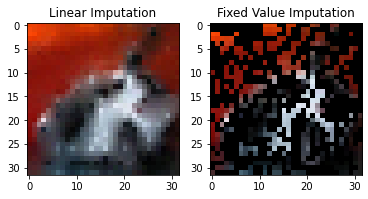

In [51]:
# plot an example
image_id=6
f, (ax1, ax2) = plt.subplots(1, 2)
show_img(ax1, ds_test_imputed_lin, image_id)
ax1.set_title("Linear Imputation")
show_img(ax2, ds_test_imputed_fix, image_id)
ax2.set_title("Fixed Value Imputation")

## Run the ROAD Benchmark

In [52]:
# the exact percentages used in our runtime benchmarks. We used the same values for ROAR.
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
print(percentages)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]


In [ ]:
%%time
accuracies, probs = run_road(model, cifar_test, explanation_test, transform_test, percentages, morf=True, batch_size = 32)

Running evaluation for p= 0.1
10000 313


100%|██████████| 313/313 [00:05<00:00, 52.73it/s]


Accuracy of the network on test images: 71.4900 %, average probability:  0.0994
Running evaluation for p= 0.2
10000 313


100%|██████████| 313/313 [00:05<00:00, 52.91it/s]


Accuracy of the network on test images: 66.0400 %, average probability:  0.0975
Running evaluation for p= 0.3
10000 313


100%|██████████| 313/313 [00:06<00:00, 51.74it/s]


Accuracy of the network on test images: 61.3300 %, average probability:  0.0966
Running evaluation for p= 0.4
10000 313


100%|██████████| 313/313 [00:06<00:00, 49.84it/s]


Accuracy of the network on test images: 57.2400 %, average probability:  0.0959
Running evaluation for p= 0.5
10000 313


100%|██████████| 313/313 [00:06<00:00, 50.02it/s]


Accuracy of the network on test images: 53.9300 %, average probability:  0.0938
Running evaluation for p= 0.7
10000 313


 39%|███▉      | 123/313 [00:03<00:03, 50.41it/s]

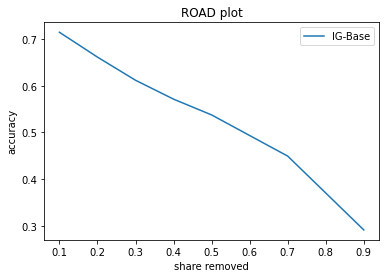

In [29]:
plt.plot(percentages, accuracies, label="IG-Base")
plt.xlabel("share removed")
plt.ylabel("accuracy")
plt.title("ROAD plot")
plt.legend()